Vamos a intentar entender (aproximadamente) cuántos puntos de lc se necesitan para una estimación correcta del período.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [129]:
import carpyncho
import feets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Funciones auxiliares
Defino funciones auxiliares que no sé dónde van porque no discutimos organización de código.

### Manipulación de curvas de luz

In [130]:
# Auxiliary functions for light curve manipulation.

# Given a light curve, calculates a period using Lomb-Scargle.
def get_period(light_curve):
    lc = light_curve.sort_values("pwp_stack_src_mag3")

    # split in time, magnitude and error
    time, mag, err = (
        lc.pwp_stack_src_hjd.values,
        lc.pwp_stack_src_mag3.values,
        lc.pwp_stack_src_mag_err3.values,
    )

    # t0 is the time with the lowest magnitude
    t0 = time[0]

    fs = feets.FeatureSpace(only=["PeriodLS", "Period_fit"])
    _, values = fs.extract(time, mag, err)
    return values[0]

# Deterioro del Período

## Obtención de los datos
Primero descargamos el tile `b278` porque es el tile favorito de Pablo. Chequeamos qué tipos de estrellas periódicas están clasificados.

In [131]:
min_obs = 43

In [132]:
# Instance the client and get the b278 tile catalogs.
client = carpyncho.Carpyncho()
b278_lc = client.get_catalog("b278", "lc")
b278_features = client.get_catalog("b278", "features")
b278_features.vs_type.unique()

<StringArray>
[           '',      'ECL-NC',  'RRLyr-RRab',   'LPV-OSARG',       'ECL-C',
     'LPV-SRV',   'RRLyr-RRc',     'ECL-ELL',    'LPV-Mira', 'T2Cep-BLHer',
       'CV-DN', 'T2Cep-RVTau',  'T2Cep-WVir',   'RRLyr-RRd',    'SP_ECL-C',
   'SP_ECL-NC',        'BLAP',       'Cep-1',       'Cep-F']
Length: 19, dtype: string

Seguro hay alguna periódica que no conozco, pero sí conozco las RRLyrae. Me quedo con esas.

In [133]:
periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

Esto se hace lindo en un for para todas las estrellas, pero para arrancar me conformo con agarrar la que más observaciones tiene.

In [134]:
# for star in b278_features:
star = b278_features.loc[b278_features["cnt"].idxmax()]
# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

Para cada cantidad de observaciones entre `min_obs` y la total disponible, buscamos el período.

In [135]:
period_list = []
obs_list = []
# TODO: Madre mia que feo ese +1.
for n_obs in range(min_obs, len(light_curve) + 1):
    lc_sample = light_curve.sample(n_obs)
    period = get_period(lc_sample)
    period_list.append(period)
    obs_list.append(n_obs)

A graficar!

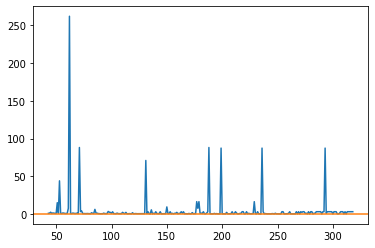

In [136]:
plt.plot(obs_list, period_list, color="tab:blue")
plt.axhline(y=star.PeriodLS, color="tab:orange")
plt.show()

Horrible. A ver la distribución respecto al módulo del período del catálogo...

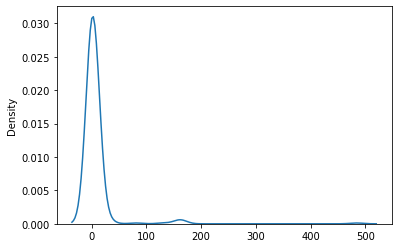

In [137]:
period_distr = np.array(period_list) / star.PeriodLS
ax = sns.kdeplot(period_distr)

Calculemos la moda.

In [138]:
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
x[y.argmax()]

3.2247305922872584

Hagamos una distribución de las modas a ver si tiene algún sentido.

In [168]:
%%capture
mode_file = open("mode_file", "a")

n_iterations = 1
for _ in range(n_iterations):
    period_list = []
    # TODO: Madre mia que feo ese +1.
    for n_obs in range(min_obs, len(light_curve) + 1):
        lc_sample = light_curve.sample(n_obs)
        period = get_period(lc_sample)
        period_list.append(period)

    period_distr = np.array(period_list) / star.PeriodLS
    ax = sns.kdeplot(period_distr)
    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    mode_file.write(f"{x[y.argmax()]}\n")

2.0234304816506055

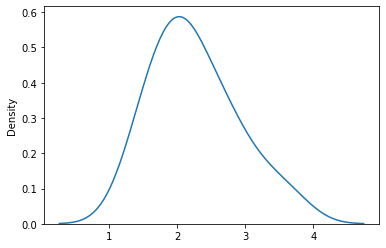

In [185]:
ax = sns.kdeplot(np.loadtxt("mode_file"))
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
x[y.argmax()]